## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path

import os
import random

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [2]:
# Defining Data path

train_path = 'face_data/emotion_classification/train/'
test_path = 'face_data/emotion_classification/test/'

list_train_images = os.listdir(train_path)
list_test_images = os.listdir(test_path)

### Utils

In [3]:
def get_image_label_pair(path, list_images):
    '''
    INPUTS:
        path: path to images
        list_images: List containing names to images in path

    RETURNS:
        X: List containing images (flattened to vectors) 
        T: Labels for the images
    '''
    X = []
    T = []

    for i in range(len(list_images)):
        images_path = Path(path+f"{list_images[i]}")
        img = np.array(Image.open(images_path), np.float32)
        img = img.reshape(-1)
        X.append(img.tolist())

        name = list_images[i]
        ti = name.split('.')
        ti = ti[1]
        T.append(ti)
        
    return X, T


### Loading Training/ Testing Data

In [4]:
X_train, Y_train = get_image_label_pair(train_path, list_train_images)
X_train = np.array(X_train)

X_test, Y_test = get_image_label_pair(test_path, list_test_images)
X_test = np.array(X_test)

print('Training data: ', X_train.shape,'\tTesting data: ', X_test.shape)

Training data:  (20, 10201) 	Testing data:  (10, 10201)


## Standardizing features before PCA

In [5]:
scaler = StandardScaler()

# Fitting on Train data to get its mean and std
scaler.fit(X_train) 
X_train = scaler.transform(X_train)

# Using Training data's mean and std to standardize test data
X_test = scaler.transform(X_test)

## PCA

In [6]:
def get_PCA(X_train, X_test, k):
    '''
    INPUTS:
        X_train/X_test: Training/test input data
        k: Number of PCA components

    RETURNS:
        Projected Training/test input data to 'k' PCA dimensions
    '''
    pca = PCA(n_components=k, whiten=True) #k=12

    # Fitting on Train data to get its mean and std
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)

    # Using Training data's PCA projection matrix to project test data to lower dim
    X_test_pca = pca.transform(X_test)

    return X_train_pca, X_test_pca


X_train, X_test = get_PCA(X_train, X_test, k=12)
print(X_train.shape, X_test.shape)

(20, 12) (10, 12)


In [7]:
# Preparing target labels

Y_train = [0 if x=='sad' else 1 for x in Y_train]
Y_test = [0 if x=='sad' else 1 for x in Y_test]


In [8]:
class Linear_Layer():
    '''
        Single Linear layer object
        y = W^T * X + b
    '''
    def __init__(self, in_features, out_features, random_state):
        '''
            Initializing weights for Linear_layer object
        '''
        
        # Seeding to reproduce results
        np.random.seed(random_state)

        self.W = np.random.randn(in_features, out_features) * np.sqrt(1. / out_features)
        self.Vw = np.random.randn(in_features, out_features) * np.sqrt(1. / out_features)
        self.b = np.zeros(shape = (1, out_features))
        self.Vb = np.zeros(shape = (1, out_features))
    

    def forward(self, x):
        '''
            Forward prop of a linear layer
        '''
        self.x = x
        score = np.dot(x, self.W) + self.b 
        return score
    

    def backward(self, grad_from_loss):
        '''
            Backward prop of a linear layer
        '''

        self.del_W = np.zeros_like(self.W)
        self.del_b = np.zeros_like(self.b)

        self.del_W =  (1/self.x.shape[0]) * np.dot(self.x.T, grad_from_loss)
        self.del_b =  (1/self.x.shape[0]) * np.sum(grad_from_loss, axis=0).reshape(1, -1)

        backward_grad = np.dot(grad_from_loss, self.W.T)
        
        return (self.del_W, self.del_b), backward_grad
    

    def update(self, lr, gamma, reg):
        '''
            gamma = 0 : Stocastic gradient descent (SGD)
            gamma > 0 : SGD + Momentum
            reg = 0   : Without L2 regularization [weigth decay]
            reg > 0   : With L2 regularization [weight decay]
        '''
        self.Vw = gamma * self.Vw + (1-gamma) * (self.del_W + reg * self.W)
        self.W = self.W - lr * self.Vw

        self.Vb = gamma * self.Vb + (1-gamma) * (self.del_b + reg * self.b)
        self.b = self.b - lr * self.Vb



In [9]:
class ReLU():
    '''
        ReLU Activation function
    '''
    def __init__(self):
        pass
    
    def forward(self, x):
        return np.maximum(x, 0)
    
    def backward(self, x, grad_from_loss):
        x[x>0] = 1
        x[x<0] = 0
        return x * grad_from_loss


In [10]:
class Model():
    
    def __init__(self, input_size, hidden_size, output_size, lr, random_state = 42, gamma = 0.9, reg = 1e-4):
        '''
            Initializing parameters for our 2 hidden-layer NN
        '''

        self.linear_1 = Linear_Layer(input_size, hidden_size, random_state)
        self.linear_2 = Linear_Layer(hidden_size, hidden_size, random_state)
        self.linear_3 = Linear_Layer(hidden_size, output_size, random_state)
        self.output_size = output_size
        self.lr = lr
        self.gamma = gamma
        self.reg = reg
        self.relu = ReLU()

    def forward(self, x):
        '''
            Forward prop from all linear layers
        '''

        ll1_out = self.linear_1.forward(x)
        x = self.relu.forward(ll1_out)

        ll2_out = self.linear_2.forward(x)
        x = self.relu.forward(ll2_out)

        o = self.linear_3.forward(x)

        # Subtracting max value before softmax to prevent potential NaN(s)
        o = o - np.max(o, axis=-1).reshape(-1,1)
        p = np.exp(o) / np.sum(np.exp(o), axis=-1).reshape(-1,1)
        
        return ll1_out, ll2_out, o, p 

    
    def backward(self, ll1_out, ll2_out, grad_from_loss):
        '''
            Backpropagating gradient from loss through all layers
        '''
        
        _, del_a2 = self.linear_3.backward(grad_from_loss.T)
        del_a2 = self.relu.backward(ll2_out, del_a2)

        _, del_a1 = self.linear_2.backward(del_a2)
        del_a1 = self.relu.backward(ll1_out, del_a1)

        _, _ = self.linear_1.backward(del_a1)


    def update(self):
        '''
            Uppdating weights and biases of linear layers
        '''

        self.linear_1.update(self.lr, self.gamma, self.reg)
        self.linear_2.update(self.lr, self.gamma, self.reg)
        self.linear_3.update(self.lr, self.gamma, self.reg)


In [11]:
def criterion(o, y):
    '''
        Returns Cross entropy loss : -ve log of softmax for true label
    '''
    loss = []
    for i in range(len(y)):
        score = o[i]
        true = y[i]
        loss_i = np.exp(score[true]) / np.sum(np.exp(score)) + eps        # eps to prevent divide_by_zero error in log
        loss_i = -np.log(loss_i)
        loss.append(loss_i)
    
    return np.mean(loss)


def compute_acc(p, Y_train):
    '''
        Computes accuracy of model predictions
    '''
    p = np.argmax(p, axis=-1)
    
    return np.mean(p==Y_train)
        

In [12]:
# Comnfigurations

lr = 5e-1               # Learning Rate
input_size = 12         # Input dimensions
hidden_size = 15        # Hidden layer dimensions [# of nodes]
output_size = 2         # Output dimensions
eps = 1e-40             # Small value to prevent error in log
epochs = 20             # Number of iterations of backprop
random_state = 6        # Random_State to reproduce results
gamma = 0               # Momentum parameter
reg = 1e-2              # L2 Regularization parameter

# Initializing model weights
model = Model(input_size, hidden_size, output_size, lr, random_state, gamma, reg)

ITER: 1  Loss: 0.6804887042815146 Acc: 0.6
ITER: 2  Loss: 0.3405653871464961 Acc: 0.9
ITER: 3  Loss: 0.2552195017801381 Acc: 0.95
ITER: 4  Loss: 0.1771152335944625 Acc: 0.95
ITER: 5  Loss: 0.13924366827939733 Acc: 0.95
ITER: 6  Loss: 0.11747413099787807 Acc: 1.0
ITER: 7  Loss: 0.1007775361333012 Acc: 1.0
ITER: 8  Loss: 0.09015308764530357 Acc: 1.0
ITER: 9  Loss: 0.07932906803862969 Acc: 1.0
ITER: 10  Loss: 0.07103879402929872 Acc: 1.0
ITER: 11  Loss: 0.0647579894075988 Acc: 1.0
ITER: 12  Loss: 0.05785143034851421 Acc: 1.0
ITER: 13  Loss: 0.05194511405376392 Acc: 1.0
ITER: 14  Loss: 0.045692037027736436 Acc: 1.0
ITER: 15  Loss: 0.04137831310310891 Acc: 1.0
ITER: 16  Loss: 0.03729600520169237 Acc: 1.0
ITER: 17  Loss: 0.033927525939650566 Acc: 1.0
ITER: 18  Loss: 0.03145433733692407 Acc: 1.0
ITER: 19  Loss: 0.029107735345438368 Acc: 1.0
ITER: 20  Loss: 0.027234941140022846 Acc: 1.0


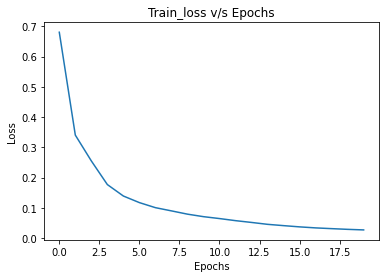

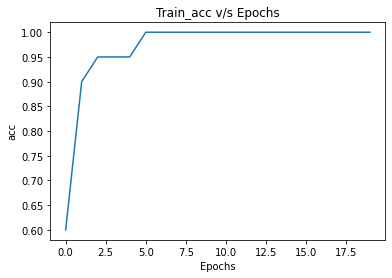

In [13]:
# Training for 20 iterations
losses = []
accuracy = []

for i in range(epochs):

    ll1_out, ll2_out, o, p = model.forward(X_train)

    loss = criterion(o, Y_train)
    acc = compute_acc(p, Y_train)
    losses.append(loss.item())
    accuracy.append(acc)

    # Computing del L / del (un_normalized outputs)
    grad_from_loss = p
    for j in range(grad_from_loss.shape[0]):
        grad_from_loss[j][Y_train[j]] -= 1

    model.backward(ll1_out, ll2_out, grad_from_loss.T)
    model.update()

    print(f'ITER: {i+1}  Loss: {loss.item()} Acc: {acc.item()}')

plt.plot(losses, label='loss')
plt.title('Train_loss v/s Epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

plt.plot(accuracy, label='acc')
plt.title('Train_acc v/s Epochs')
plt.ylabel('acc')
plt.xlabel('Epochs')
plt.show()


## Predicting on Test data

In [14]:
ll1_out, ll2_out, o, p = model.forward(X_test)

loss = criterion(o, Y_test)
acc = compute_acc(p, Y_test)

print("Predictions:\t",np.argmax(p, axis=-1))
print("True targets:\t",Y_test)
print("Test Loss:\t",loss)
print("Test accuracy:\t",acc)

Predictions:	 [1 1 0 1 0 0 1 1 0 1]
True targets:	 [1, 1, 0, 0, 1, 0, 1, 1, 0, 1]
Test Loss:	 0.33586281457526435
Test accuracy:	 0.8
